### Import Dependencies

In [1]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from datetime import datetime
from skimage.transform import resize
from skimage.color import rgb2gray
from torch.utils.tensorboard import SummaryWriter
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import pandas as pd
import matplotlib.pyplot as plt

/home/sprince0031/.local/lib/python3.10/site-packages/tensorflow/__init__.py:30: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils as _distutils
2025-05-11 13:08:04.770537: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 13:08:06.354036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Neural Network for the DQN
class DQN(nn.Module):
    def __init__(self, action_space, dueling=False):
        super(DQN, self).__init__()
        self.dueling = dueling
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)

        if self.dueling:
            self.value = nn.Linear(512, 1)
            self.advantage = nn.Linear(512, action_space)
        else:
            self.fc2 = nn.Linear(512, action_space)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))

        if self.dueling:
            value = self.value(x)
            advantage = self.advantage(x)
            return value + (advantage - advantage.mean(dim=1, keepdim=True))
        else:
            return self.fc2(x)

In [4]:
# Preprocessing
def preprocess_observation(obs):
    gray = rgb2gray(obs)
    resized = resize(gray, (84, 84), mode='constant')
    return np.uint8(resized * 255)

In [5]:
# Replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [6]:
# Action Selection
def select_action(state, epsilon, action_space, policy_net):
    if random.random() < epsilon:
        return random.randrange(action_space)
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = policy_net(state_tensor)
        return q_values.argmax(1).item()

In [7]:
# -Target Calculation
def compute_targets(batch, policy_net, target_net, gamma, double_dqn):
    states = torch.FloatTensor(np.array([b[0] for b in batch])).to(device)
    actions = torch.LongTensor(np.array([b[1] for b in batch])).to(device)
    rewards = torch.FloatTensor(np.array([b[2] for b in batch])).to(device)
    next_states = torch.FloatTensor(np.array([b[3] for b in batch])).to(device)
    dones = torch.FloatTensor(np.array([b[4] for b in batch])).to(device)

    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        if double_dqn:
            next_actions = policy_net(next_states).argmax(1)
            next_qs = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            next_qs = target_net(next_states).max(1)[0]

        targets = rewards + (1 - dones) * gamma * next_qs

    return q_values, targets

In [8]:
def plot_training_metrics(reward_history,td_losses=None,window=50,label_prefix=""):
    
    def moving_avg(data, k):
        return np.convolve(data, np.ones(k)/k, mode='valid')

    plt.figure(figsize=(12, 5))

    # Plot reward
    plt.subplot(1, 2, 1)
    plt.plot(reward_history, label=f'{label_prefix}Reward')
    plt.plot(pd.Series(reward_history).rolling(window).mean(), label=f'{label_prefix}Avg{window}')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Episode Reward")
    plt.legend()
    plt.grid(True)

    # Plot TD loss
    if td_losses is not None:
        plt.subplot(1, 2, 2)
        plt.plot(moving_avg(td_losses, window), label=f'{label_prefix}TD Loss (Avg{window})')
        plt.xlabel("Minibatch Step")
        plt.ylabel("Loss")
        plt.title("TD Loss")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    
    
    plt.show()
    plt.close()


In [9]:
env_name='ALE/Breakout-v5'
env = gym.make(env_name, render_mode='rgb_array', obs_type='rgb')
action_space = env.action_space.n


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [10]:
save_dir="./models"

In [11]:
# Training function
def train_dqn(episodes=1000,epsilon_start=1.0,epsilon_min=0.1,epsilon_decay=0.995,lr=0.0001,gamma=0.99,save_tag="dqn"):

    policy_net = DQN(action_space, dueling=use_dueling_dqn).to(device)
    target_net = DQN(action_space, dueling=use_dueling_dqn).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    replay_buffer = ReplayBuffer(100000)
    batch_size = 32
    target_update = 10
    epsilon= epsilon_start

    best_avg_reward = -float('inf')
    best_total_reward = -float('inf')
    reward_history = []
    td_losses=[]

    os.makedirs(save_dir, exist_ok=True)

    #Training loop
    for episode in range(episodes):
        obs, _ = env.reset()
        processed = preprocess_observation(obs)
        state = np.stack([processed] * 4, axis=0)
        total_reward = 0
        done = False

        while not done:
            action = select_action(state, epsilon, action_space, policy_net)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_processed = preprocess_observation(next_obs)
            next_state = np.append(state[1:], np.expand_dims(next_processed, 0), axis=0)

            replay_buffer.add((state, action, reward, next_state, float(done)))
            state = next_state
            total_reward += reward

            if len(replay_buffer) > batch_size:
                batch = replay_buffer.sample(batch_size)
                q_vals, targets = compute_targets(batch, policy_net, target_net, gamma, use_double_dqn)
                loss = criterion(q_vals, targets.detach())
                td_losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                td_losses.append(loss.item())

        epsilon = max(epsilon*epsilon_decay, epsilon_min)
        reward_history.append(total_reward)
        avg_reward = np.mean(reward_history[-50:])
        

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if total_reward > best_total_reward:
            best_total_reward = total_reward
            torch.save(policy_net.state_dict(), f'{save_dir}/best_total_{save_tag}.pth')
            print(f"[Episode {episode}] New best total reward: {total_reward:.2f}, model saved.")

        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            torch.save(policy_net.state_dict(), f'{save_dir}/best_avg_{save_tag}.pth')
            print(f"[Episode {episode}] New best avg reward: {avg_reward:.2f}, model saved.")

        print(f"Episode {episode} | Total Reward: {total_reward} | Avg50: {avg_reward:.2f} | Epsilon: {epsilon:.2f}")

    env.close()
    print(f"Best Total Reward = {best_total_reward}")
    
    #plot results
    plot_training_metrics(reward_history, td_losses, window=50, label_prefix=f"{save_tag}: ")



In [12]:
# Evaluation
def evaluate_model(model_path, env_name='ALE/Breakout-v5', tag='eval', dueling=False):
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=f"./videos/{tag}", episode_trigger=lambda x: True)
    action_space = env.action_space.n

    model = DQN(action_space, dueling=dueling).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    obs, _ = env.reset()
    state = np.stack([preprocess_observation(obs)] * 4, axis=0)
    done = False

    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_tensor).argmax(1).item()
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        processed = preprocess_observation(obs)
        state = np.append(state[1:], np.expand_dims(processed, 0), axis=0)

    env.close()
    print(f"Video saved at ./videos/{tag}")

### Vanilla DQN

https://github.com/yunjhongwu/Double-DQN-Breakout/blob/master/README.md

[Episode 0] New best total reward: 3.00, model saved.
[Episode 0] New best avg reward: 3.00, model saved.
Episode 0 | Total Reward: 3.0 | Avg50: 3.00 | Epsilon: 1.00
Episode 1 | Total Reward: 1.0 | Avg50: 2.00 | Epsilon: 1.00
Episode 2 | Total Reward: 1.0 | Avg50: 1.67 | Epsilon: 1.00
[Episode 3] New best total reward: 6.00, model saved.
Episode 3 | Total Reward: 6.0 | Avg50: 2.75 | Epsilon: 1.00
Episode 4 | Total Reward: 2.0 | Avg50: 2.60 | Epsilon: 1.00
Episode 5 | Total Reward: 2.0 | Avg50: 2.50 | Epsilon: 1.00
Episode 6 | Total Reward: 0.0 | Avg50: 2.14 | Epsilon: 1.00
Episode 7 | Total Reward: 2.0 | Avg50: 2.12 | Epsilon: 1.00
Episode 8 | Total Reward: 1.0 | Avg50: 2.00 | Epsilon: 1.00
Episode 9 | Total Reward: 5.0 | Avg50: 2.30 | Epsilon: 1.00
Episode 10 | Total Reward: 2.0 | Avg50: 2.27 | Epsilon: 0.99
Episode 11 | Total Reward: 2.0 | Avg50: 2.25 | Epsilon: 0.99
Episode 12 | Total Reward: 2.0 | Avg50: 2.23 | Epsilon: 0.99
Episode 13 | Total Reward: 1.0 | Avg50: 2.14 | Epsilon: 0

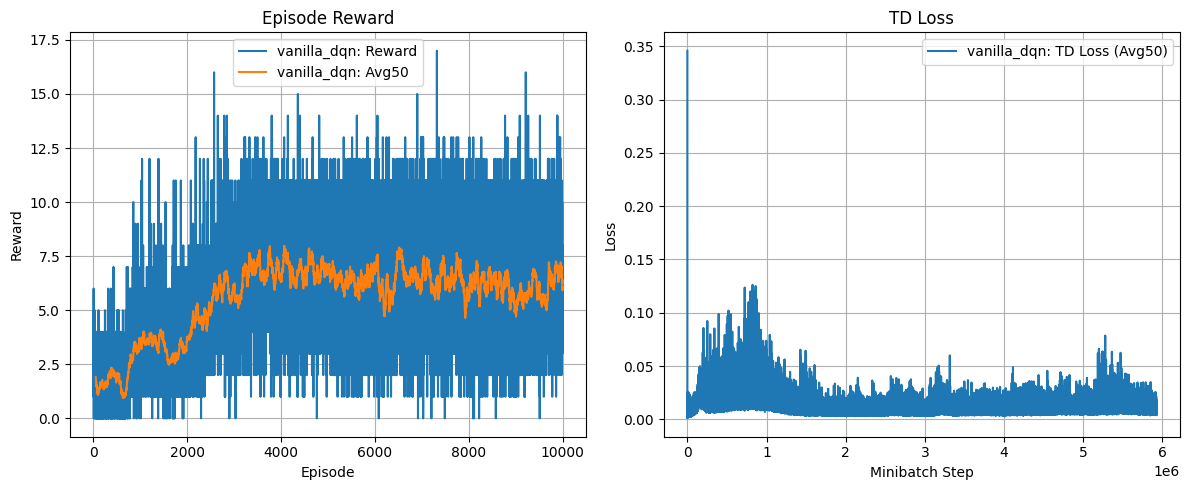

In [13]:
use_double_dqn = False
use_dueling_dqn = False
save_tag = 'vanilla_dqn' 

train_dqn(episodes=10000,epsilon_start=1.0,epsilon_min=0.1,epsilon_decay=0.9995,lr=0.0001,gamma=0.99,save_tag=save_tag)

In [19]:
evaluate_model('models/best_avg_vanilla_dqn.pth', tag='vanilla_dqn', dueling=False)
vids = [f for f in os.listdir('./videos/vanilla_dqn') if f.endswith('.mp4')]
Video(f'./videos/vanilla_dqn/{vids[-1]}', embed=True)


MoviePy - Building video /home/sprince0031/Thendral/Code/DQN Project/Breakout/videos/vanilla_dqn/rl-video-episode-0.mp4.
MoviePy - Writing video /home/sprince0031/Thendral/Code/DQN Project/Breakout/videos/vanilla_dqn/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/sprince0031/Thendral/Code/DQN Project/Breakout/videos/vanilla_dqn/rl-video-episode-0.mp4
Video saved at ./videos/vanilla_dqn


### Double DQN

In [ ]:
use_double_dqn = True
use_dueling_dqn = False
save_tag = 'double_dqn' 

train_dqn(episodes=10000,epsilon_start=1.0,epsilon_min=0.1,exploration_phase=0.7,lr=0.0001,gamma=0.99,save_tag=save_tag)

In [ ]:
evaluate_model('models/best_total_double_dqn.pth', tag='double_dqn', dueling=False)
vids = [f for f in os.listdir('./videos/double_dqn') if f.endswith('.mp4')]
Video(f'./videos/double_dqn/{vids[-1]}', embed=True)

### Dueling DQN

In [ ]:
use_double_dqn = False
use_dueling_dqn = True
save_tag = 'double_dqn' 

train_dqn(episodes=10000,epsilon_start=1.0,epsilon_min=0.1,exploration_phase=0.7,lr=0.0001,gamma=0.99,save_tag=save_tag)

In [ ]:
evaluate_model('models/best_dueling_dqn.pth', tag='dueling_dqn', dueling=True)
vids = [f for f in os.listdir('./videos/dueling_dqn') if f.endswith('.mp4')]
Video(f'./videos/dueling_dqn/{vids[-1]}', embed=True)